In [1]:
from google.colab import drive
import os
drive.mount('/gdrive')
os.getcwd()
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Mounted at /gdrive


'/content'

In [2]:
root = "/gdrive/My Drive/CS470/cs470_music_generator"
root_data = '/gdrive/My Drive/CS470/data'
root_midi = '/gdrive/My Drive/CS470/data/midi'
os.chdir(root)
os.getcwd()

'/gdrive/My Drive/CS470/cs470_music_generator'

In [3]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 7.6MB/s 


In [4]:
import torch.optim as optim
from torch.optim import SGD
import pickle
import re

import gc
import os
import random
import time
import math

import numpy as np
import sentencepiece as spm
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from tqdm import tqdm

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def word_encode(words_arr, word):
    return (words_arr == word).astype(np.float).reshape(1,-1)

def word_mapping(words_arr, word):
    return words_arr[word]

## Initialization - Lyrics Model

In [7]:
lines = list(map(lambda x: x.strip(), open("data/cleaned_lyrics.txt", encoding="utf-8").readlines()))
lines = '\n'.join(lines)
print(lines[:100])


well she was just  if you know what i mean
and the way she looked
was way beyond compare
so how cou


In [8]:
words_arr = np.array(list(set(re.findall(r'\S+|\n', lines))))
n_words = len(words_arr)
words_arr
n_words

4405

In [9]:
with open("data/words_arr.pkl", "bw") as fd:
  pickle.dump(words_arr, fd)

In [10]:
'\n' in words_arr

True

In [11]:
lyrics_x = torch.FloatTensor([word_encode(words_arr, x) for x in re.findall(r'\S+|\n', lines)])
lyrics_x = lyrics_x.to(device)

## Initialization - MIDI Model

In [12]:
!git clone https://github.com/bearpelican/musicautobot.git

fatal: destination path 'musicautobot' already exists and is not an empty directory.


In [13]:
os.chdir('musicautobot')
os.getcwd()

'/gdrive/My Drive/CS470/cs470_music_generator/musicautobot'

In [14]:
!apt-get update
!apt install musescore fluidsynth

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://security.ubuntu.com/ubuntu bionic-security/universe amd6

In [15]:
!pip install torch fastai music21 pebble fluidsynth midi2audio

  Created wheel for fluidsynth: filename=fluidsynth-0.2-cp36-none-any.whl size=4513 sha256=44771267bf1b1af61e8d0c679c07da984435608441f5c074c68168a51135871d
  Stored in directory: /root/.cache/pip/wheels/2d/70/4d/ffe2589bbfe9c268780570a6875583fbf59547004459e2c3c3
Successfully built fluidsynth


In [16]:
from musicautobot.numpy_encode import *
from musicautobot.config import *
from musicautobot.music_transformer import *
from musicautobot.multitask_transformer import *
from musicautobot.utils import midifile

In [17]:
os.chdir('..')
os.getcwd()

'/gdrive/My Drive/CS470/cs470_music_generator'

In [18]:
embed = False
transformer = False

In [19]:
def plot_music(x):
  npenc = idxenc2npenc(x, music_vocab)
  item = MusicItem.from_npenc(npenc, music_vocab)
  item.show()
  return item

In [20]:
with open("data/dataset_np.pkl", "rb") as fd:
  music_data = pickle.load(fd)

with open("data/music_vocab.pkl", "rb") as fd:
  music_vocab = pickle.load(fd)
  
train_data = list(map(lambda x: x["np"], music_data))
train_data[0]

tensor([  0,   1,   8,  ..., 189,  49, 189])

In [21]:
X_train = np.concatenate(train_data, axis=0)
music_arr = np.array(list(set(X_train)))
n_characters = len(music_arr)
n_characters, music_arr

(169, array([  0,   1,   8,  30, ..., 249, 257, 258, 265]))

In [22]:
with open("data/music_arr.pkl", "bw") as fd:
  pickle.dump(music_arr, fd)

In [23]:
if embed:
  music_x = torch.LongTensor([word_encode(music_arr, np.array(x)) for x in X_train])
else:
  music_x = torch.FloatTensor([word_encode(music_arr, np.array(x)) for x in X_train])
music_x = music_x.to(device)

## Models

In [24]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, embed):
        super(Model,self).__init__()

        self.embed = embed
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        self.cell = nn.GRU(input_size=hidden_size if embed else input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        
        self.fc = nn.Linear(hidden_size,output_size)
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        
    def forward(self,input):
        batch_size = input.size()[0]
        hidden = self._init_hidden(batch_size)
        if self.embed:
            x_ = self.encoder(input)
        else:
            x_ = input
        output, hidden = self.cell(x_, hidden)
        fc_output = self.fc(output.view(-1, hidden_size))
        return fc_output
    
    def forward2(self, input, hidden):
        if self.embed:
            x_ = self.encoder(input)
        else:
            x_ = input
        output,hidden = self.cell(x_,hidden)
        fc_output = self.fc(output.view(-1, hidden_size))
        return fc_output, hidden
    
    def _init_hidden(self,batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return hidden

In [25]:
input_size = n_words
hidden_size = 256 
num_layers = 1
output_size = n_words

lyrics_model = Model(input_size, hidden_size, num_layers, output_size, False).to(device)

lyrics_optimizer = optim.Adam(lyrics_model.parameters(), lr=.005)
lyrics_loss_fn = nn.CrossEntropyLoss()
lyrics_scheduler = optim.lr_scheduler.StepLR(lyrics_optimizer, step_size=250, gamma=0.97)

loss_lyrics_list = []

chunk_len_lyrics = 200

lyrics_model

Model(
  (cell): GRU(4405, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=4405, bias=True)
  (encoder): Embedding(4405, 256)
)

In [26]:
input_size = n_characters
hidden_size = 64 if embed else 256 
num_layers = 1 # one-layer rnn
output_size = n_characters
batch_size = 8
input_size

if transformer:
  music_model = nn.Transformer(d_model=n_characters, nhead=13, num_encoder_layers=1, num_decoder_layers=1).to(device)
else:
  music_model = Model(input_size, hidden_size, num_layers, output_size, embed).to(device)


music_optimizer = optim.Adam(music_model.parameters(),lr=.005)
music_loss_fn = nn.CrossEntropyLoss()
music_scheduler = optim.lr_scheduler.StepLR(music_optimizer, step_size=250, gamma=0.97)


loss_music_list = []
loss_list=[]

chunk_len_music = 400

music_model

Model(
  (cell): GRU(169, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=169, bias=True)
  (encoder): Embedding(169, 256)
)

## Concurrent Training

In [27]:
def random_chunk(X, chunk_len):
    start_index = torch.randint(0, X.size()[0]-chunk_len, (1, 1))
    end_index = start_index + chunk_len + 1
    char_chunk = X[start_index:end_index]
    return char_chunk[:-1].permute(1,0,2), char_chunk[1:].argmax(dim=2).squeeze()

def random_chunk_trans(X, chunk_len):
    start_index = torch.randint(0, X.size()[0]-chunk_len, (1, 1))
    end_index = start_index + chunk_len + 1
    char_chunk = X[start_index:end_index]
    return char_chunk[:-1].permute(1,0,2), char_chunk[1:].permute(1,0,2)

In [28]:
lambda_lr = 1

In [29]:
epochs = 5000
for epoch in range(epochs):
    #music
    music_optimizer.zero_grad()
    if transformer:
      xb, yb = random_chunk_trans(music_x, chunk_len_music) 
      if embed:
        _, xb = torch.max(xb, dim=2)
      output = music_model(xb, yb)
      loss_music = music_loss_fn(output, torch.max(yb, dim=1)[1])
    else:
      xb, yb = random_chunk(music_x, chunk_len_music) 
      if embed:
        _, xb = torch.max(xb, dim=2)
      output = music_model(xb)
      loss_music = music_loss_fn(output, yb)

    ## lyrics
    lyrics_optimizer.zero_grad()
    xb, yb = random_chunk(lyrics_x, chunk_len_lyrics)
    output = lyrics_model(xb)
    loss_lyrics = lyrics_loss_fn(output, yb)

    loss = loss_music + lambda_lr * loss_lyrics

    loss.backward()
    music_optimizer.step()
    lyrics_optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(epoch + 1,'/', epochs," Loss: ", loss.item(), sep='')    

    loss_list.append(loss.item())
    loss_music_list.append(loss_music.item())
    loss_lyrics_list.append(loss_lyrics.item())

    music_scheduler.step()
    lyrics_scheduler.step()
  
torch.save(music_model, "models/model_music{}.pt".format(lambda_lr))
torch.save(music_optimizer, "models/optimizer_music{}.pt".format(lambda_lr))

torch.save(lyrics_model, "models/model_lyrics{}.pt".format(lambda_lr))
torch.save(lyrics_optimizer, "models/optimizer_lyrics{}.pt".format(lambda_lr))

100/5000 Loss: 8.526338577270508
200/5000 Loss: 6.752013206481934
300/5000 Loss: 6.444555282592773
400/5000 Loss: 5.760181903839111
500/5000 Loss: 4.392717361450195
600/5000 Loss: 4.697322368621826
700/5000 Loss: 4.740467071533203
800/5000 Loss: 5.394284248352051
900/5000 Loss: 4.584438800811768
1000/5000 Loss: 4.355813980102539
1100/5000 Loss: 5.7224955558776855
1200/5000 Loss: 3.7964258193969727
1300/5000 Loss: 2.254789113998413
1400/5000 Loss: 3.608900547027588
1500/5000 Loss: 2.4218838214874268
1600/5000 Loss: 2.9899425506591797
1700/5000 Loss: 5.282479763031006
1800/5000 Loss: 1.7153394222259521
1900/5000 Loss: 2.548142671585083
2000/5000 Loss: 2.711294651031494
2100/5000 Loss: 1.2401615381240845
2200/5000 Loss: 1.5905961990356445
2300/5000 Loss: 2.4732351303100586
2400/5000 Loss: 1.203141212463379
2500/5000 Loss: 1.679569959640503
2600/5000 Loss: 2.2002334594726562
2700/5000 Loss: 1.7817867994308472
2800/5000 Loss: 1.4187062978744507
2900/5000 Loss: 2.5959415435791016
3000/5000 L

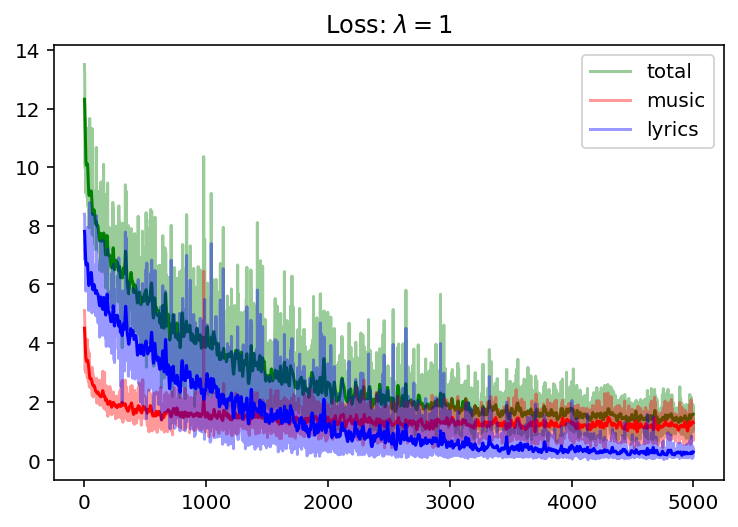

In [31]:
from scipy.ndimage import gaussian_filter1d

plt.plot(loss_list, label="total", alpha=0.4, color="green")
plt.plot(gaussian_filter1d(loss_list, sigma=4), color="green")

plt.plot(loss_music_list, label="music", alpha=0.4, color="red")
plt.plot(gaussian_filter1d(loss_music_list, sigma=4), color="red")

plt.plot(loss_lyrics_list, label="lyrics", alpha=0.4, color="blue")
plt.plot(gaussian_filter1d(loss_lyrics_list, sigma=4), color="blue")

plt.title("Loss: $\lambda={}$".format(lambda_lr))

plt.legend()

In [ ]:
def generate(model, max_n=None, max_tokens=300, temperature=0.7, top_k=32, arr=None, embed=None, lyrics=False):
    text = []
    # start_sent = encode_text(start_sent)
    letter = random.randint(0, max_n)  
    if embed:
      letter = [letter]
    if lyrics:
      letter = [word_mapping(arr, letter)]
    if type(letter) == list:
      text.append(letter[0])
    else:
      text.append(word_mapping(arr, letter) if lyrics else letter)
    hidden = model._init_hidden(1)
    with torch.no_grad():
        for i in range(max_tokens):
          tmp = word_encode(arr, letter)
          if embed:
            letter, hidden = model.forward2(torch.LongTensor(np.argmax(tmp, axis=1)).unsqueeze(0).to(device), hidden)
          else:
            letter, hidden = model.forward2(torch.FloatTensor(tmp).unsqueeze(0).to(device), hidden)
          if (i+1)%2 == 0:
              letter = arr[torch.multinomial(F.softmax(letter.view(1,-1)),1)]
          else:
              letter = arr[letter.view(1,-1).argmax(1)]
          text.append(letter)
    if embed:
      tmp = [i if type(i) != list else i[0] for i in text]
      text = tmp
    return text

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


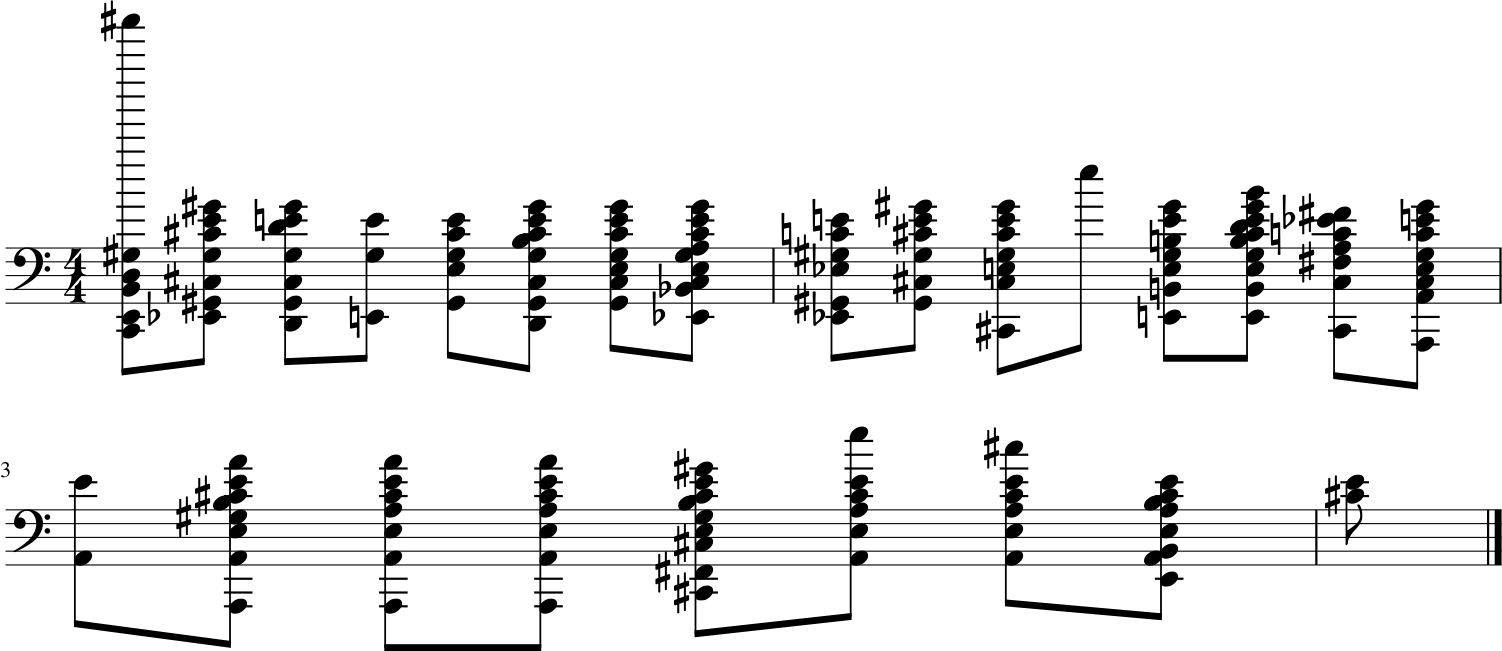

theyve lost someone 
 many time ive cried 
 anyway you do 
 youll be the only one and then there was love 
 so many hair of wondering what youre asleep 
 well baby youre gonna carry that weight 
 carry that weight a long time 
 why do i think you dont need no need 
 be true 
 do love me do 
 tell me that you love me baby 
 i love you 
 hello hello 
 i dont know why you say goodbye i say hello 
 hello goodbye hello goodbye hello hello 
 hello goodbye i dont know why you say goodbye i say goodbye 
 why why say goodbye and i say hello 
 hello hello 
 i dont know why you say goodbye i say hello 
 hello i say hello 
 hello goodbye i dont know why you say goodbye i say hello 
 hello goodbye i say hello 
 hello i say hello 
 hello goodbye i dont know why you say goodbye i say hello 
 hello goodbye i say hello 
 hello goodbye i dont know why you say goodbye i say you dont word 
 say hello little


In [ ]:
# saved_model_path = "models/model_music"
# if transformer:
#   print("Transformer does not learn, possibly because of the size of the dataset")
# else: 
#   model = Model(input_size, hidden_size, num_layers, output_size, embed).to(device)
#   model.load_state_dict(torch.load(saved_model_path, map_location=device))
#   model.eval()

lyrics_length = 500

output = generate(music_model, max_n=n_characters, max_tokens=lyrics_length, arr=music_arr, embed=embed)
item = plot_music(np.array(output))

output = generate(lyrics_model, max_n=n_words, max_tokens=200, arr=words_arr, embed=False, lyrics=True)
print(' '.join(output))

In [ ]:
item.stream.write('midi', fp='music/complete.midi')

'music/complete.midi'

In [ ]:
torch.load("models/model_music{}.pt".format(lambda_lr))

Model(
  (cell): GRU(169, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=169, bias=True)
  (encoder): Embedding(169, 256)
)